Define values for Data Points

In [4702]:
!pip install numpy
!pip install pandas 
!pip install matplotlib
!pip install scikit-learn

In [4703]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans

# Define Sigma Values

In [4704]:
sigma_list = np.linspace(0.1,2, num = 20 ,dtype=float)
sigma_list=np.round(sigma_list,1)
print(sigma_list)
print(sigma_list.shape)

# sigma_list= [0.1,0.3,0.5,0.7,0.9,1,1.5,2,2.5,3.5,4,20]

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]
(20,)


# Initialise performance variables

In [4705]:
accuracy_list_1=[]
accuracy_list_2=[]
accuracy_list_3=[]
mse_list_1=[]
mse_list_2=[]
mse_list_3=[]
tst_accuracy_list_1=[]
tst_accuracy_list_2=[]
tst_accuracy_list_3=[]
tst_mse_list_1=[]
tst_mse_list_2=[]
tst_mse_list_3=[]


In [4706]:
weights_1=[]
weights_2=[]
weights_3=[]


In [4707]:
np.random.seed(1)

# Functions to create Dataset

In [4708]:
#Here i=0,1,2...20, returns float
def value_func(i):
    return round(-2+0.2*i,2)

# Returns list of values that x1,x2 can take
def value_gen(max_val):
    i_list = np.linspace(0, 20, num = 21,dtype=int)
    print("Range of i and j is : ",i_list) # Gives the range of i,j
    values_list=list(map(value_func,i_list))
    print("List of values",values_list)
    return values_list

#Returns a 441x2 np_array which is the training data. 441 samples with 2 input features each
def random_train_samples(value_list):
    train_data = []
    for num_samples in range(441):
        row = []  
        for num_features in range(2):
            row.append(random.choice(value_list))
        train_data.append(row) 
    train_data=np.array(train_data)
    return train_data

# train_pt is a 1x2 np array, returns int
def squared_sum(train_pt):
    return (train_pt[0]**2)+(train_pt[1]**2)

# Returns a 441x1 np array containing the output labels as per f(x1,x2)
def train_labels(train_data):
    labels=[]       #Output Labels
    square_sum=[]   # To evaluate (x1^2 + x2^2) , returns (441,1)
    for i in range(train_data.shape[0]):
        square_sum.append(squared_sum(train_data[i]))
        if squared_sum(train_data[i])<=1:
            labels.append(1)
        else:
            labels.append(-1)
    labels=np.array(labels)
    labels=np.reshape(labels,(441,1))
    square_sum=np.array(square_sum)
    square_sum=np.reshape(square_sum,(441,1))
    return labels,square_sum


def train_test_split(X,Y):
    
    # Shuffled indices of samples
    shuffled_indices=np.random.permutation(np.arange(X.shape[0]))

    X_shuff= X[shuffled_indices]
    Y_shuff= Y[shuffled_indices]

    # Ratio of Training Samples
    train_split = 0.8
    num_train = int(train_split*X_shuff.shape[0])

    # Training Data
    X_train= X_shuff[:num_train]
    Y_train= Y_shuff[:num_train]

    # Validation Data
    X_val= X_shuff[num_train:]
    Y_val = Y_shuff[num_train:]
    
    return X_train,Y_train,X_val,Y_val


# Functions to create Centres

In [4709]:
#returns rbf centres-441x2 matrix
def rbf_centres_all(train_data):
    return train_data

def rbf_centres_random(train_data):
#     rbf_centres =np.empty((150,2))
#     for num_samples in range(150):
#         rbf_centres[num_samples]=random.choice(train_data)
#     return rbf_centres

    # Select 150 random indices with replacement
    centres = np.random.choice(train_data.shape[0], size=150, replace=False)

    # Create a new array using the random indices
    centres = train_data[centres, :]
    return centres


# def rbf_centres_random(train_data):
#     n = train_data.shape[0]

#     random_args = np.random.choice(n,150)
#     centers = train_data[random_args]
#     return centers

def rbf_centres_kmeans(train_data,K):
#     kmeans = KMeans(n_clusters=K,n_init='auto').fit(train_data)
    kmeans = KMeans(n_clusters=K,random_state=0).fit(train_data)
    centres=kmeans.cluster_centers_
    return centres


# Functions for Interpolation

In [4710]:
def gaussian_kernel(ip_array, center_vector, sigma):
    x=np.exp(-np.linalg.norm(ip_array - center_vector)**2 / (2 * sigma**2))
    return x



def rbf(train_data,centres,sigma):
    phi = np.zeros((train_data.shape[0], centres.shape[0]))
    print("Shape of phi is:",phi.shape)
    for i in range(train_data.shape[0]):
        for j in range(centres.shape[0]):
            phi[i, j] = gaussian_kernel(train_data[i], centres[j], sigma)
    return phi

def weights(rbf_output,op_labels):
    G_pinv=np.linalg.pinv(rbf_output)
    D=op_labels
    W=np.dot(G_pinv,D)
    return W

def predict(W,G):
#     Y=np.dot(W.T,G)
    Y=np.dot(G,W)
    Y=np.array(Y)
    Y=np.sign(Y)
    return Y


# Functions to evaluate performance

In [4711]:
def calculate_accuracy(pred_op,actual_op):
    accuracy = np.mean(pred_op == actual_op) * 100
    return accuracy

def calculate_mse(pred_op,actual_op):
    mse= np.mean((pred_op - actual_op) ** 2)*100
    return mse


# Functions to visualise data

In [4712]:

def plot(train_data, labels, ptype):
    inside_circle = train_data[labels.flatten() == 1.0]
    outside_circle = train_data[labels.flatten() == -1.0]
    plot_type = {1: "Train Points", 2: "RBF-All", 3: "RBF-Random", 4: "RBF-KMeans"}


    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot inside circle points
    ax.scatter(inside_circle[:, 0], inside_circle[:, 1], color='orangered', label='Inside Circle')
    
    # Plot outside circle points 
    ax.scatter(outside_circle[:, 0], outside_circle[:, 1], color='mediumblue', label='Outside Circle')
    

    ax.set_xlabel('x1', fontsize=12)
    ax.set_ylabel('x2', fontsize=12)
    ax.set_title('Points Inside and Outside Circle - ' + plot_type[ptype], fontsize=14, fontweight='bold')

    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)
    fig.tight_layout()
    plt.show()


In [4713]:
def acc_mse_plot(perc_list,sig_list,mse=False):
    
    plt.figure(figsize=(12,6))
    plt.plot(sig_list, perc_list, marker='o', linestyle='-', color='b')
    
    plt.xlabel('Sigma',fontsize=12)
    if mse:
        plt.ylabel('Mean Squared Error in %',fontsize=12)
        plt.title('Sigma v/s MSE Graph',fontsize=12,fontweight='bold')
    else:
        plt.ylabel('Accuracy in %',fontsize=12)
        plt.title('Sigma v/s Accuracy Graph',fontsize=12,fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()  

In [4714]:
def comp_plot(acc_list_1,acc_list_2,acc_list_3,sig_list,mse=False):
    
    plt.figure(figsize=(16,10))
    
    if mse:
        plt.plot(sig_list,mse_list_1,marker='o', linestyle='-',color="red",label="All")
        plt.plot(sig_list,mse_list_2,marker='o', linestyle='--',color="blue",label="Random")
        plt.plot(sig_list,mse_list_3,marker='o', linestyle='-.',color="green",label="KMeans")
        plt.xlabel('Sigma',fontsize=12)
        plt.ylabel('MSE in %',fontsize=12)
        plt.title('Sigma v/s MSE Graph',fontsize=12,fontweight='bold')
        
    else:
        plt.plot(sig_list,acc_list_1,marker='o', linestyle='-',color="red",label="All")
        plt.plot(sig_list,acc_list_2,marker='o', linestyle='--',color="blue",label="Random")
        plt.plot(sig_list,acc_list_3,marker='o', linestyle='-.',color="green",label="KMeans")
        plt.xlabel('Sigma',fontsize=12)
        plt.ylabel('Accuracy in %',fontsize=12)
        plt.title('Sigma v/s Accuracy Graph',fontsize=12,fontweight='bold')
    
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.legend(fontsize=10)
    plt.tight_layout()

# RBF Function

In [4715]:
# def RBF_NN(train_data,op_labels,sigma,quest,K=None):
    
#     if quest==1:
#         rbf_centres=rbf_centres_all(train_data)
#     elif quest==2:
#         rbf_centres=rbf_centres_random(train_data)
#     elif quest==3:
#         rbf_centres=rbf_centres_kmeans(train_data,K)
    
    
#     rbf_output=rbf(train_data,rbf_centres,sigma)
#     W=weights(rbf_output,op_labels)
#     print("Shape of weights is:",W.shape)
#     Y_train=predict(W,rbf_output)
    
#     accuracy_train=calculate_accuracy(Y_train,op_labels)
#     mse_train=calculate_mse(Y_train,op_labels)
    
#     if quest==1:
#         accuracy_list_1.append(accuracy_train)
#         mse_list_1.append(mse_train)
#     elif quest==2:
#         accuracy_list_2.append(accuracy_train)
#         mse_list_2.append(mse_train)
#     elif quest==3:
#         accuracy_list_3.append(accuracy_train)
#         mse_list_3.append(mse_train)
        
#     return W,Y_train


def RBF_NN(train_data,rbf_centres,op_labels,sigma,quest,K=None):
    
    rbf_output=rbf(train_data,rbf_centres,sigma)
    W=weights(rbf_output,op_labels)
    print("Shape of weights is:",W.shape)
    Y_train=predict(W,rbf_output)
    
    accuracy_train=calculate_accuracy(Y_train,op_labels)
    mse_train=calculate_mse(Y_train,op_labels)
    
    if quest==1:
        accuracy_list_1.append(accuracy_train)
        mse_list_1.append(mse_train)
    elif quest==2:
        accuracy_list_2.append(accuracy_train)
        mse_list_2.append(mse_train)
    elif quest==3:
        accuracy_list_3.append(accuracy_train)
        mse_list_3.append(mse_train)
        
    return W,Y_train


In [4716]:
def RBF_NN_predict(train_data,rbf_centres,weights,test_data,test_labels,sigma,quest,K=None):

#     if quest==1:
#         rbf_centres=rbf_centres_all(train_data)
#     elif quest==2:
#         rbf_centres=rbf_centres_random(train_data)
#     elif quest==3:
#         rbf_centres=rbf_centres_kmeans(train_data,K)
        
    print("Shape of rbf centres is:",rbf_centres.shape)
    rbf_output=rbf(test_data,rbf_centres,sigma)
    print("Shape of rbf output is:",rbf_output.shape)
#     W=weights(rbf_output,op_labels)
    Y_val=predict(weights,rbf_output)
    
    accuracy_val=calculate_accuracy(Y_val,test_labels)
#     print("Accuracy",accuracy)
    mse_val=calculate_mse(Y_val,test_labels)
    
    if quest==1:
        tst_accuracy_list_1.append(accuracy_val)
        tst_mse_list_1.append(mse_val)
    elif quest==2:
        tst_accuracy_list_2.append(accuracy_val)
        tst_mse_list_2.append(mse_val)
    elif quest==3:
        tst_accuracy_list_3.append(accuracy_val)
        tst_mse_list_3.append(mse_val)
        
    return Y_val

# def RBF_NN_predict(rbf_centres,weights,test_data,test_labels,sigma,quest,K=None):

# #     if quest==1:
# #         rbf_centres=rbf_centres_all(train_data)
# #     elif quest==2:
# #         rbf_centres=rbf_centres_random(train_data)
# #     elif quest==3:
# #         rbf_centres=rbf_centres_kmeans(train_data,K)
        
#     print("Shape of rbf centres is:",rbf_centres.shape)
#     rbf_output=rbf(test_data,rbf_centres,sigma)
#     print("Shape of rbf output is:",rbf_output.shape)
# #     W=weights(rbf_output,op_labels)
#     Y_val=predict(weights,rbf_output)
    
#     accuracy_val=calculate_accuracy(Y_val,test_labels)
# #     print("Accuracy",accuracy)
#     mse_val=calculate_mse(Y_val,test_labels)
    
#     if quest==1:
#         tst_accuracy_list_1.append(accuracy_val)
#         tst_mse_list_1.append(mse_val)
#     elif quest==2:
#         tst_accuracy_list_2.append(accuracy_val)
#         tst_mse_list_2.append(mse_val)
#     elif quest==3:
#         tst_accuracy_list_3.append(accuracy_val)
#         tst_mse_list_3.append(mse_val)
        
#     return Y_val

## Training Data

### List of values allowed

In [4717]:
values_list=value_gen(20)

Range of i and j is :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
List of values [-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]


### Save Training Samples

In [4718]:
#Save train_data
data=random_train_samples(values_list)
data_df=pd.DataFrame(data,columns=['x1','x2'])


### Compute Actual Output Labels

In [4719]:
# Save actual output labels and squared sum of x1, x2
data_op_labels,squared_op=train_labels(data)
print("Shape of Output labels is :",data_op_labels.shape)

data_df['(x1^2) + (x2^2)']=squared_op
data_df['Actual O/P']=data_op_labels
        

Shape of Output labels is : (441, 1)


### Display Training Data

In [4720]:
# Training Data Frame
data_df

,x1,x2,(x1^2) + (x2^2),Actual O/P
0,0.4,0.8,0.80,1
1,1.4,0.8,2.60,-1
2,-0.4,-1.8,3.40,-1
3,-1.2,0.0,1.44,-1
4,0.8,-1.0,1.64,-1
...,...,...,...,...
436,-0.2,-0.2,0.08,1
437,0.8,-0.4,0.80,1
438,0.6,1.6,2.92,-1
439,-0.6,-1.0,1.36,-1


### Training Data Plot

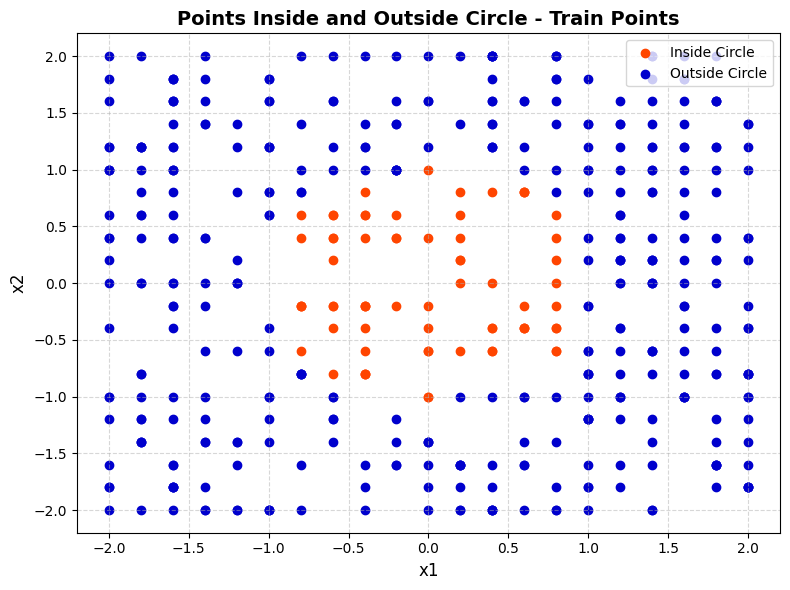

In [4721]:
plot(data,data_op_labels,1)

In [4722]:
train_data,op_labels,val_data,val_op_labels=train_test_split(data,data_op_labels)

In [4723]:
# select_randomly(train_data)

In [4724]:
# rbf_centres_random(train_data)

In [4725]:
print("Shape of train data :",train_data.shape)
print("Shape of train labels :",op_labels.shape)
print("Shape of val data :",val_data.shape)
print("Shape of val labels :",val_op_labels.shape)

Shape of train data : (352, 2)
Shape of train labels : (352, 1)
Shape of val data : (89, 2)
Shape of val labels : (89, 1)


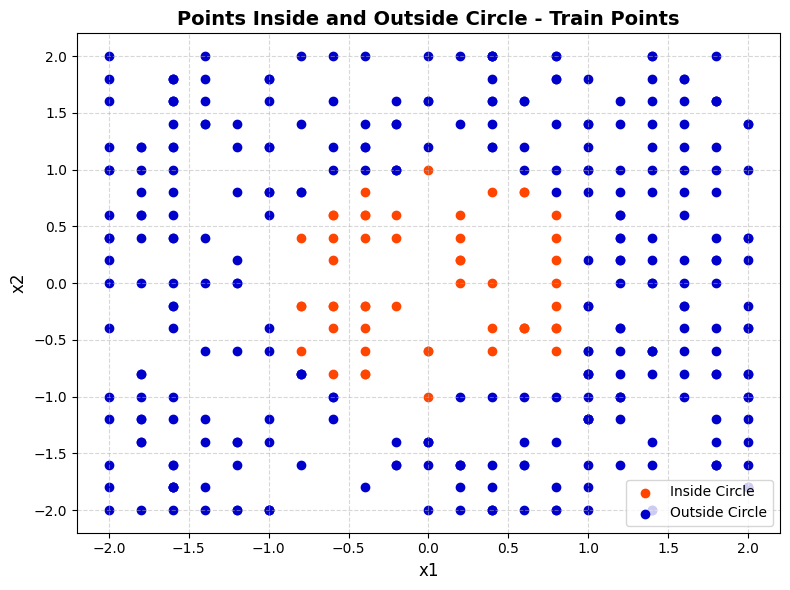

In [4726]:
plot(train_data,op_labels,1)

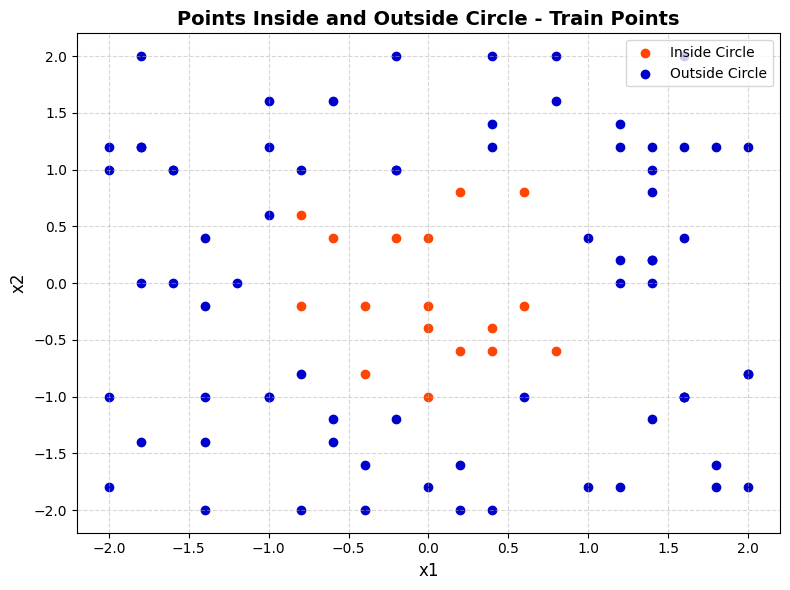

In [4727]:
plot(val_data,val_op_labels,1)

## Generate Centres

In [4728]:
rbf_centres_1=rbf_centres_all(train_data)
rbf_centres_2=rbf_centres_random(train_data)
rbf_centres_3=rbf_centres_kmeans(train_data,150)

/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Question 1

## Training

In [4729]:
output_1=[]

for sigma in sigma_list:
    weight,output=RBF_NN(train_data,rbf_centres_1,op_labels,sigma,1)
    output_1.append(output)
    weights_1.append(weight)

Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi i

In [4730]:
len(weights_1)

20

In [4731]:
type(weights_1[0])

numpy.ndarray

In [4732]:
weights_1[0].shape

(352, 1)

In [4733]:
accuracy_list_1

[100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 99.7159090909091,
 99.43181818181817,
 99.43181818181817,
 99.43181818181817,
 99.43181818181817,
 99.43181818181817,
 99.43181818181817,
 99.14772727272727,
 99.43181818181817]

In [4734]:
len(accuracy_list_1)

20

## Sigma vs Accuracy Plot

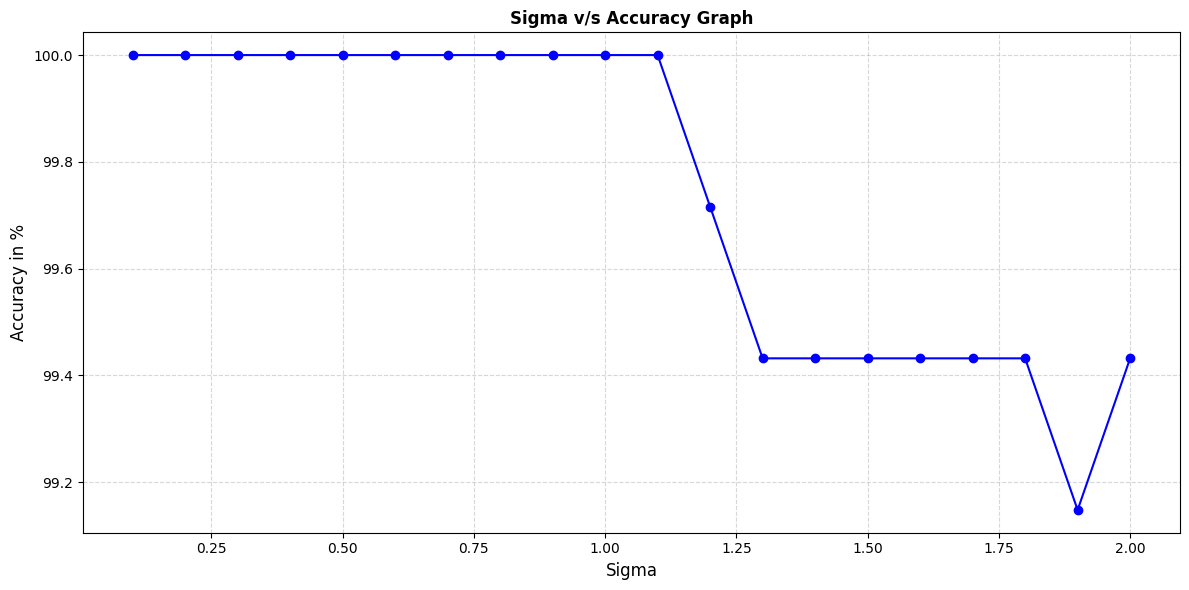

In [4735]:
acc_mse_plot(accuracy_list_1,sigma_list)

## Sigma vs MSE plot

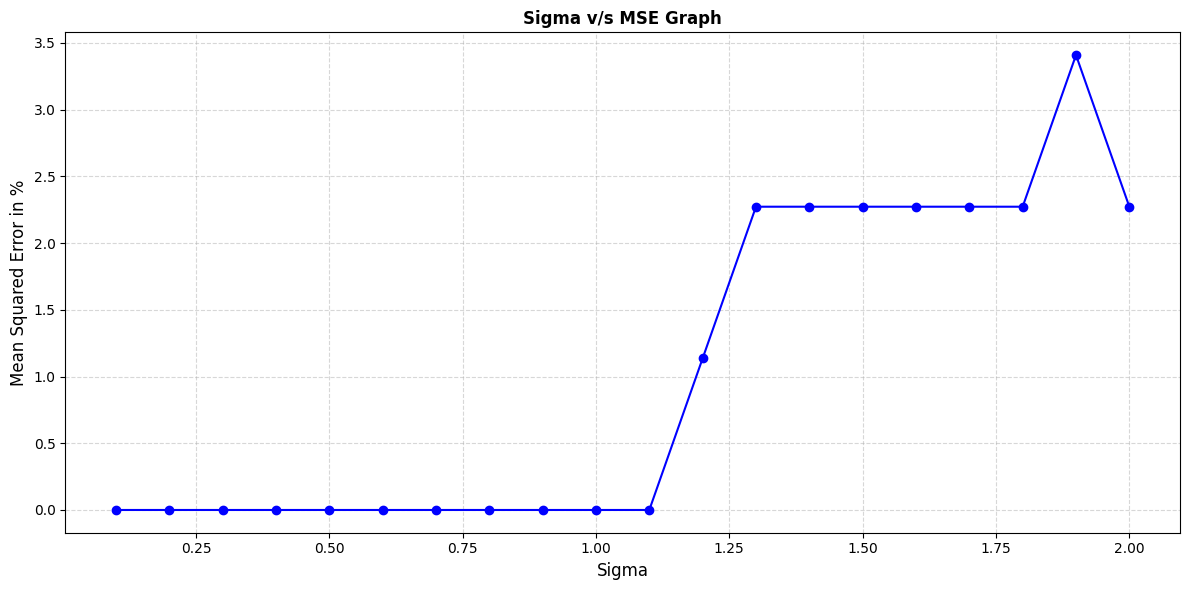

In [4736]:
acc_mse_plot(mse_list_1,sigma_list,mse=True)

## Plot Graph for Q1 at sigma with max accuracy 

20
100.0
0


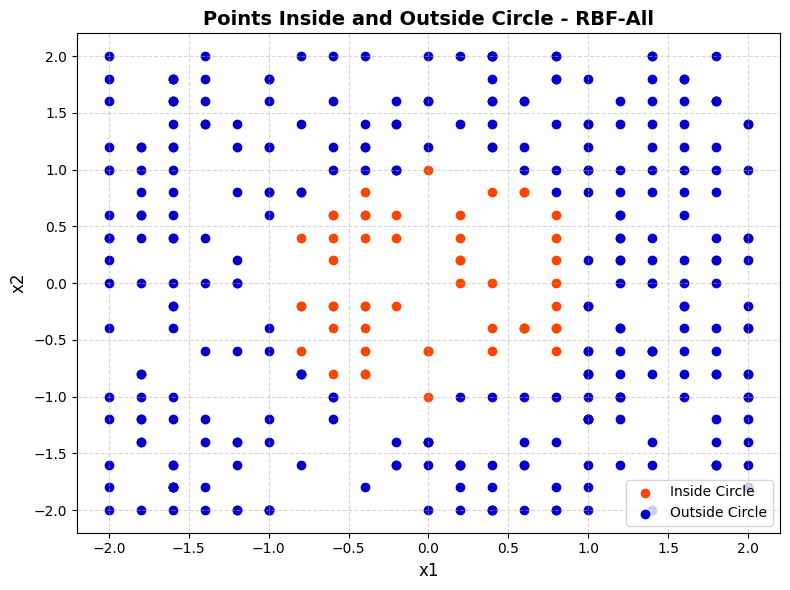

In [4737]:
print(len(output_1))
print(max(accuracy_list_1))
print(accuracy_list_1.index(max(accuracy_list_1)))
# for output in output_1:
plot(train_data,output_1[accuracy_list_1.index(max(accuracy_list_1))],2)


In [4738]:
weights_1[0]


array([[-0.66861817],
       [-0.43227726],
       [ 0.25061907],
       [ 0.89488861],
       [ 0.75151574],
       [-0.25918561],
       [-0.43227726],
       [-0.66590108],
       [-0.34681717],
       [-0.78771976],
       [ 0.45573808],
       [-0.80421382],
       [-0.38916548],
       [-0.58849988],
       [-0.4413488 ],
       [-0.78803097],
       [-0.39505842],
       [-0.5164054 ],
       [-0.35150321],
       [-0.38964177],
       [-0.39388365],
       [ 0.25061907],
       [-0.56152196],
       [-0.78969981],
       [-0.86577253],
       [ 0.3778099 ],
       [-0.76214916],
       [-0.59461872],
       [ 1.03791118],
       [ 0.94087749],
       [ 0.77585753],
       [ 0.91213959],
       [-0.19805692],
       [ 1.29533437],
       [-0.70651119],
       [-0.7909546 ],
       [-0.77360903],
       [ 0.34144713],
       [-1.05280989],
       [ 0.78561286],
       [-0.66889521],
       [-0.86018263],
       [-0.19805692],
       [-0.43296817],
       [-0.76762191],
       [-0

## Validation

In [4739]:
val_output_1=[]
i=0
for sigma in sigma_list:
    val_output_1=RBF_NN_predict(train_data,rbf_centres_1,weights_1[i],val_data,val_op_labels,sigma,1)
    i=i+1
#     tst_accuracy_list_1.append(val_output_1)

Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is:

In [4740]:
tst_accuracy_list_1

[98.87640449438202,
 98.87640449438202,
 98.87640449438202,
 97.75280898876404,
 95.50561797752809,
 94.3820224719101,
 93.25842696629213,
 95.50561797752809,
 96.62921348314607,
 94.3820224719101,
 95.50561797752809,
 97.75280898876404,
 98.87640449438202,
 100.0,
 100.0,
 100.0,
 100.0,
 98.87640449438202,
 97.75280898876404,
 97.75280898876404]

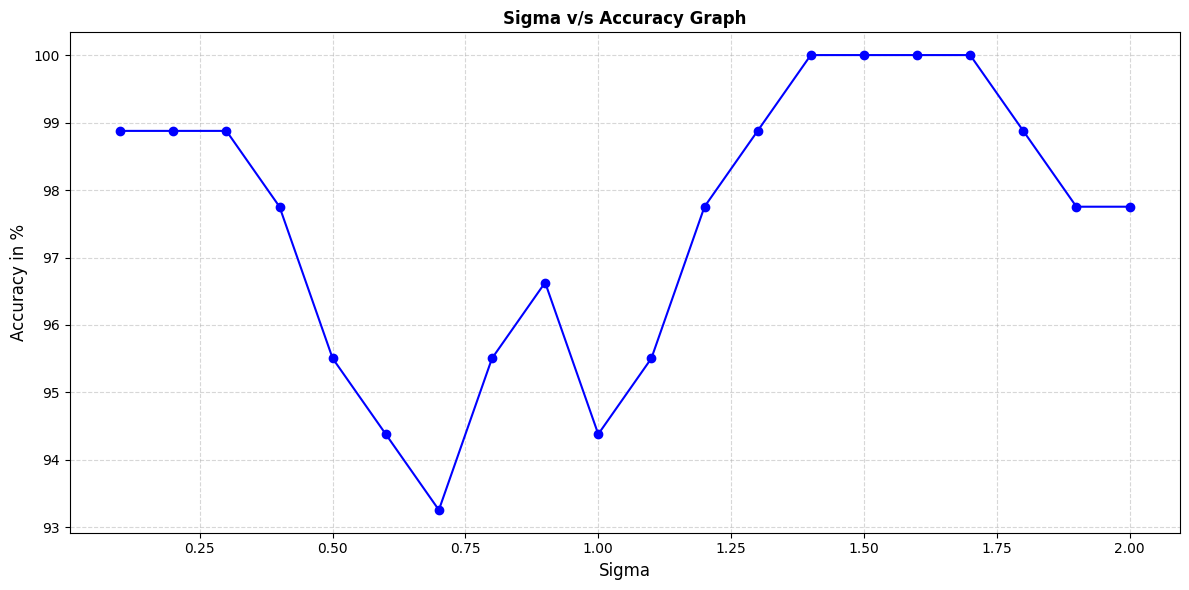

In [4741]:
acc_mse_plot(tst_accuracy_list_1,sigma_list)

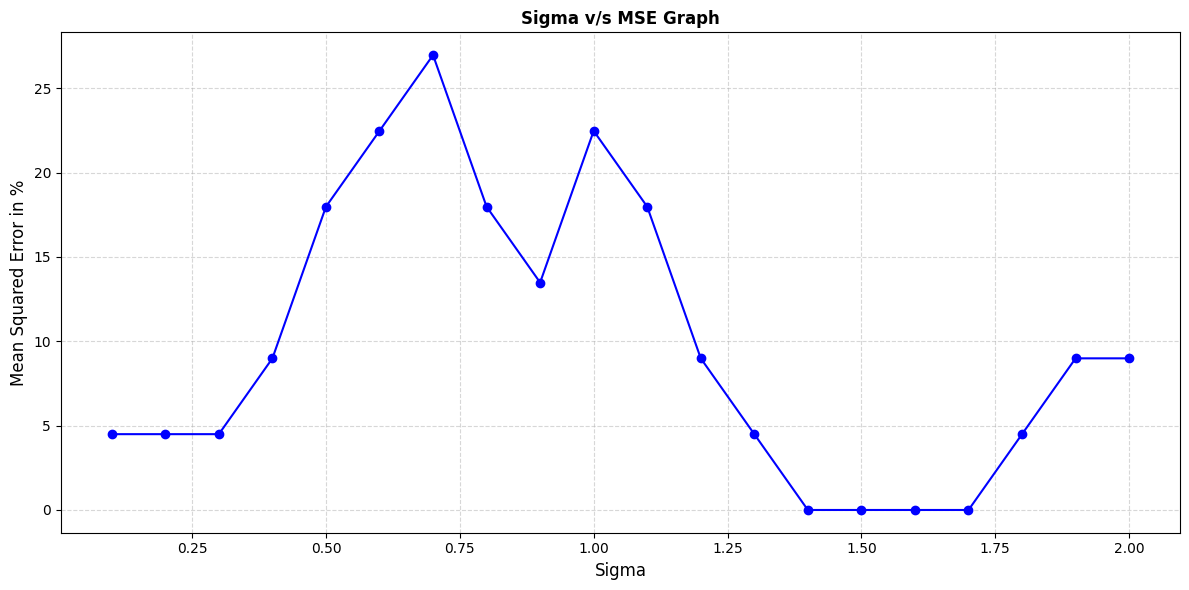

In [4742]:
acc_mse_plot(tst_mse_list_1,sigma_list,mse=True)

## Question 2


## Train

In [4743]:
outputs_2=[]

for sigma in sigma_list:
    weight,output=RBF_NN(train_data,rbf_centres_2,op_labels,sigma,2)
    outputs_2.append(output)
    weights_2.append(weight)

Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi i

In [4744]:
accuracy_list_2

[97.72727272727273,
 98.86363636363636,
 99.43181818181817,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091,
 99.43181818181817,
 99.43181818181817,
 99.43181818181817,
 99.43181818181817,
 99.43181818181817,
 99.14772727272727,
 99.43181818181817,
 99.43181818181817,
 99.43181818181817]

In [4745]:
len(accuracy_list_2)

20

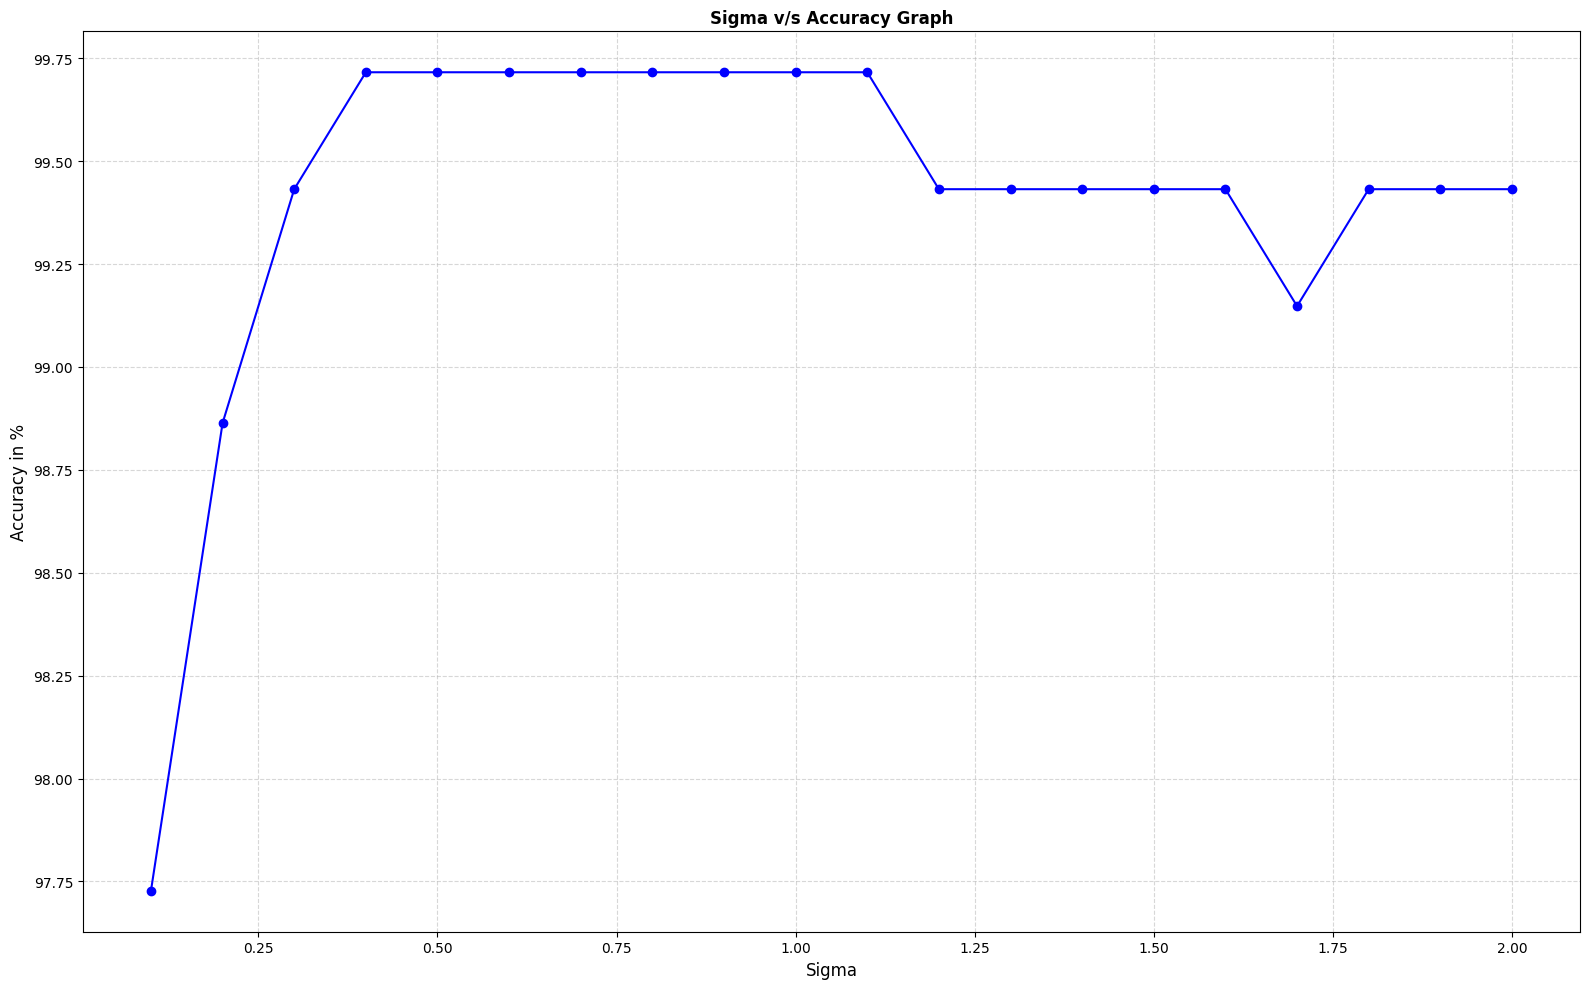

In [4746]:
acc_plot(accuracy_list_2,sigma_list)

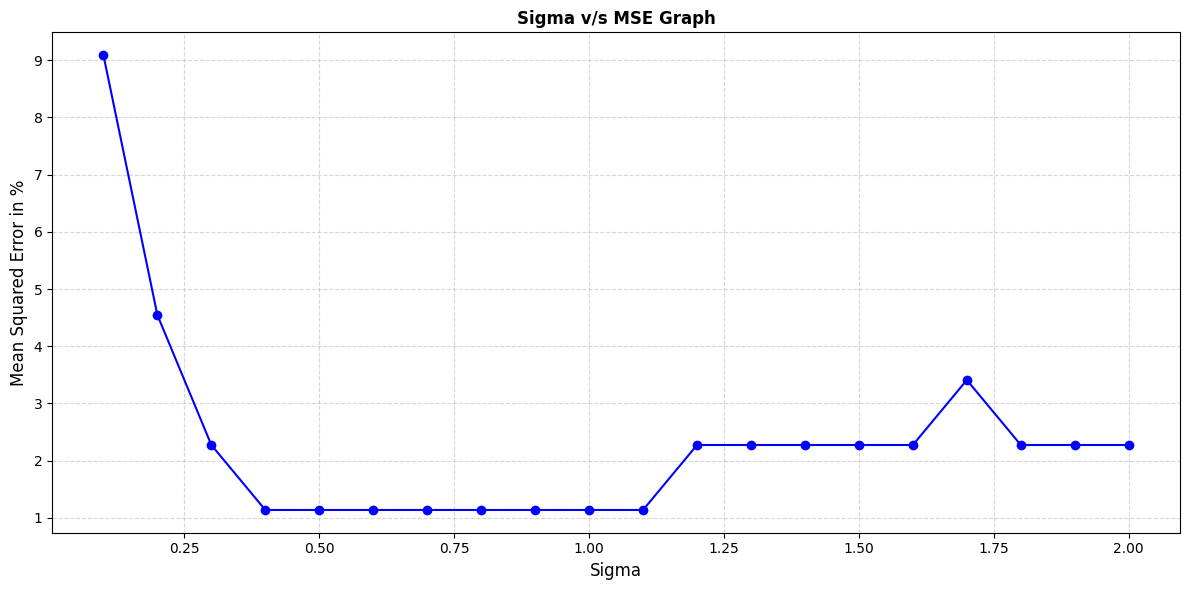

In [4747]:
acc_mse_plot(mse_list_2,sigma_list,mse=True)

In [4748]:
# print(len(output_2))
# print(max(accuracy_list_2))
# # for output in output_1:
# plot(train_data,output_2[accuracy_list_2.index(max(accuracy_list_2))],3)

In [4749]:
weights_2[0].shape

(150, 1)

## Validation

In [4750]:
val_output_2=[]
i=0
for sigma in sigma_list:
    print("i is:",i)
    val_output_2.append(RBF_NN_predict(train_data,rbf_centres_2,weights_2[0],val_data,val_op_labels,sigma,2))
    i=i+1

    

i is: 0
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
i is: 1
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
i is: 2
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
i is: 3
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
i is: 4
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
i is: 5
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
i is: 6
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
i is: 7
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
i is: 8
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
i is: 9
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shap

In [4751]:
tst_accuracy_list_2

[97.75280898876404,
 97.75280898876404,
 97.75280898876404,
 97.75280898876404,
 95.50561797752809,
 94.3820224719101,
 89.8876404494382,
 86.51685393258427,
 80.89887640449437,
 80.89887640449437,
 80.89887640449437,
 80.89887640449437,
 80.89887640449437,
 80.89887640449437,
 80.89887640449437,
 80.89887640449437,
 80.89887640449437,
 80.89887640449437,
 80.89887640449437,
 80.89887640449437]

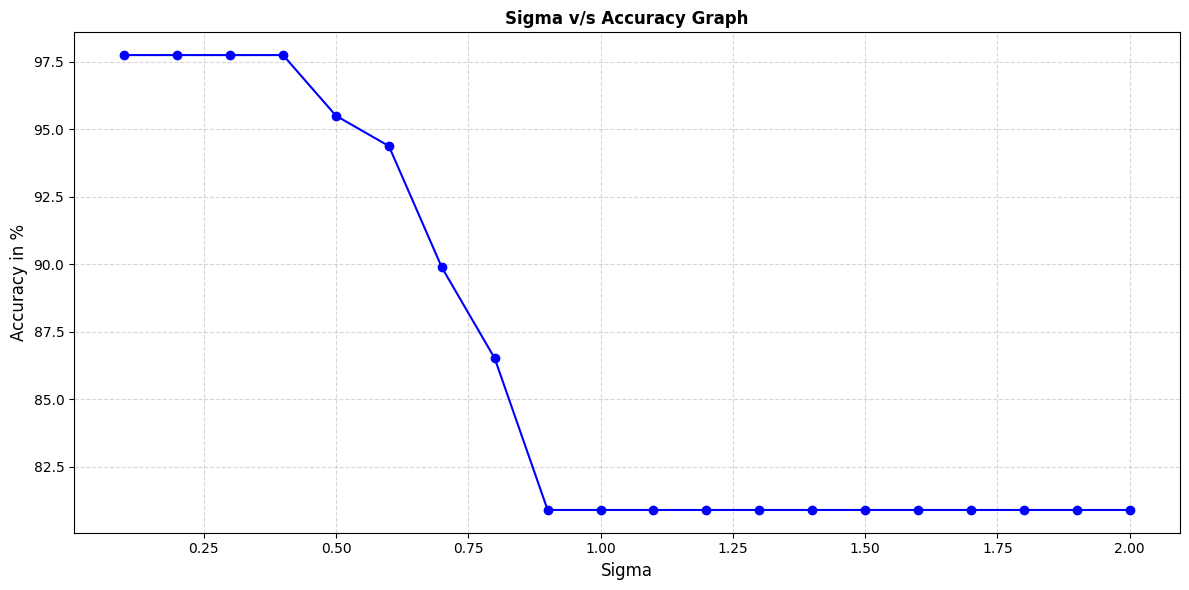

In [4752]:
acc_mse_plot(tst_accuracy_list_2,sigma_list)

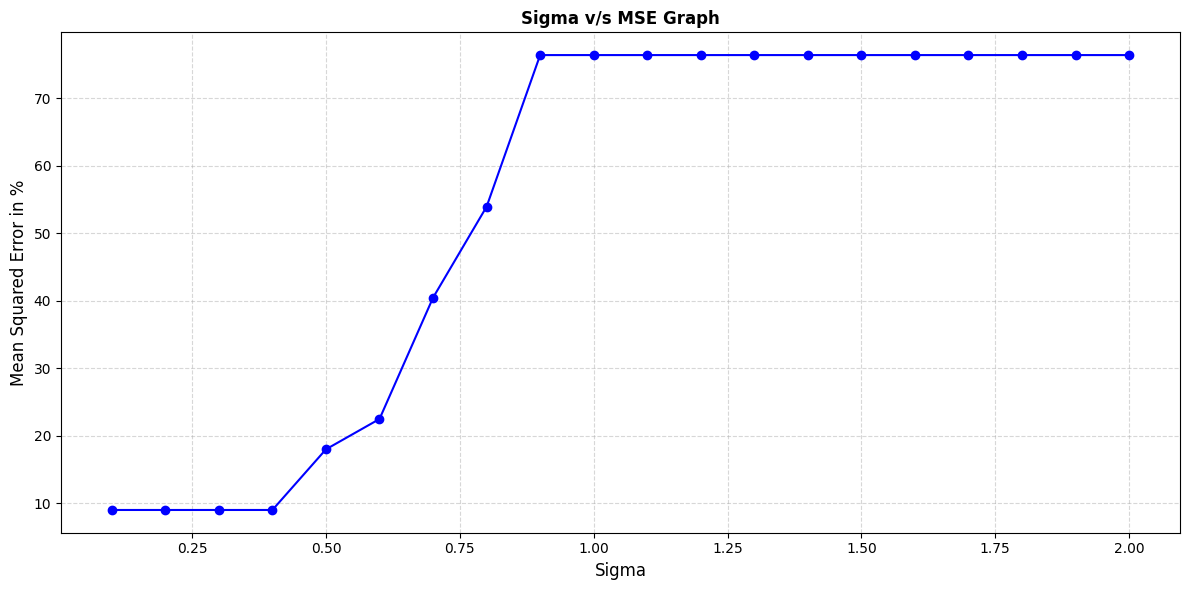

In [4753]:
acc_mse_plot(tst_mse_list_2,sigma_list,mse=True)

## Question 3

In [4754]:
output_3=[]

for sigma in sigma_list:
    weight,output=RBF_NN(train_data,rbf_centres_3,op_labels,sigma,3,K=150)
    output_3.append(output)
    weights_3.append(weight)
    

Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi i

In [4755]:
accuracy_list_3

[98.29545454545455,
 99.7159090909091,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091,
 99.43181818181817,
 99.43181818181817,
 99.43181818181817,
 99.43181818181817,
 99.43181818181817,
 99.14772727272727,
 99.14772727272727,
 99.43181818181817]

In [4756]:
len(accuracy_list_3)

20

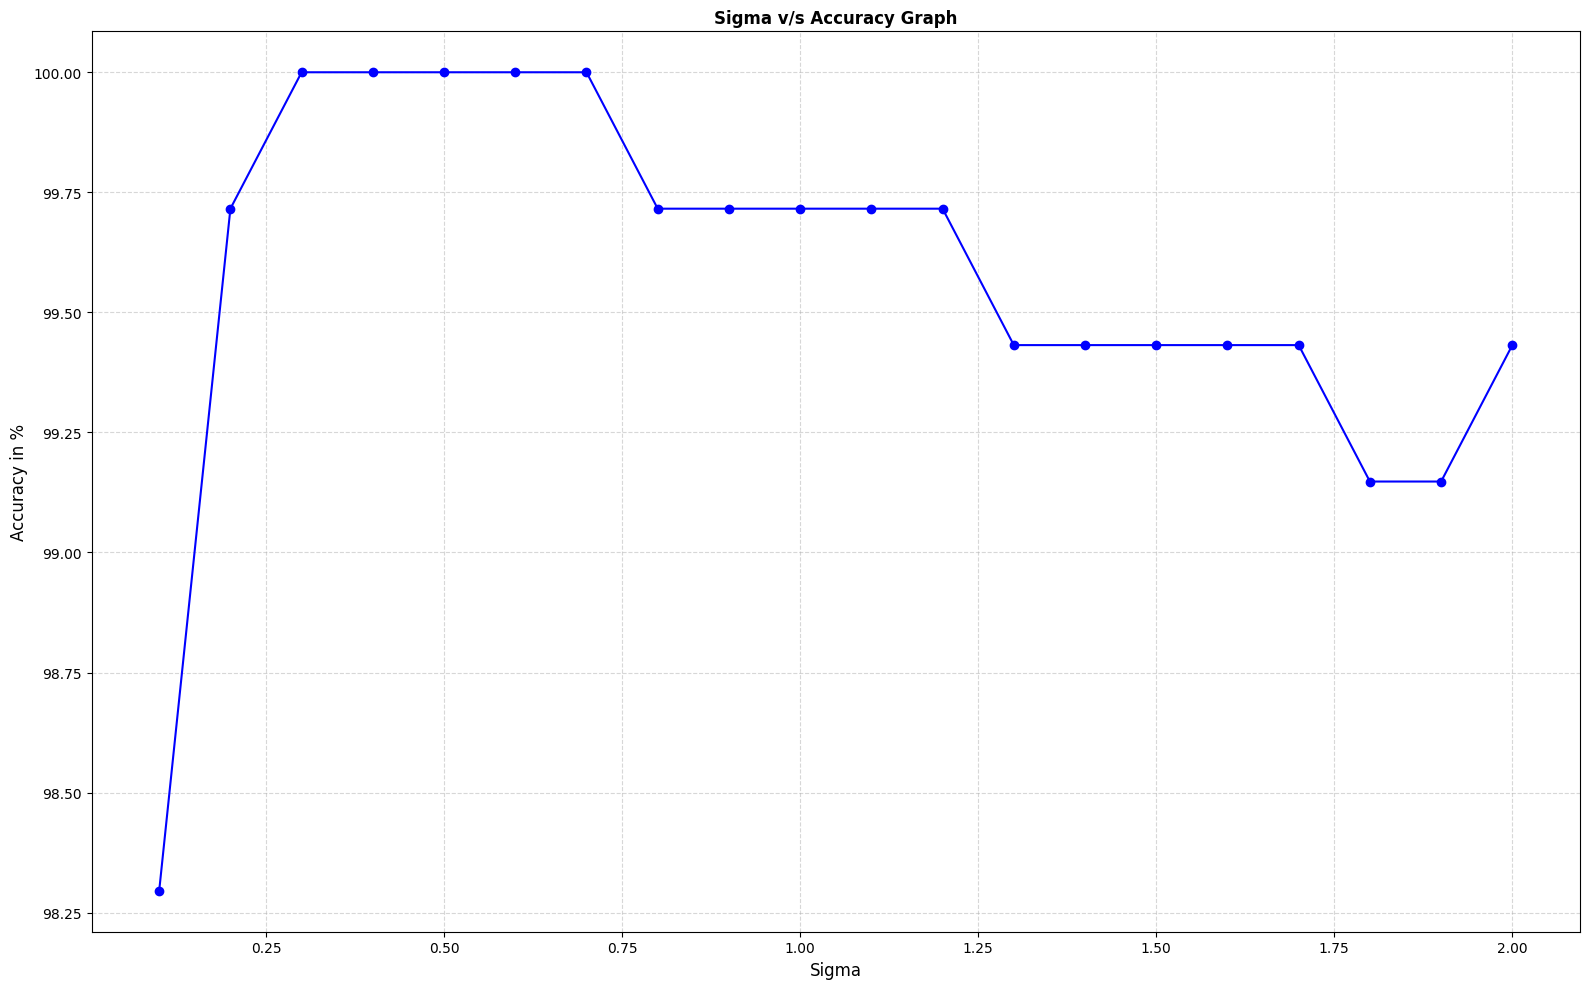

In [4757]:
acc_plot(accuracy_list_3,sigma_list)

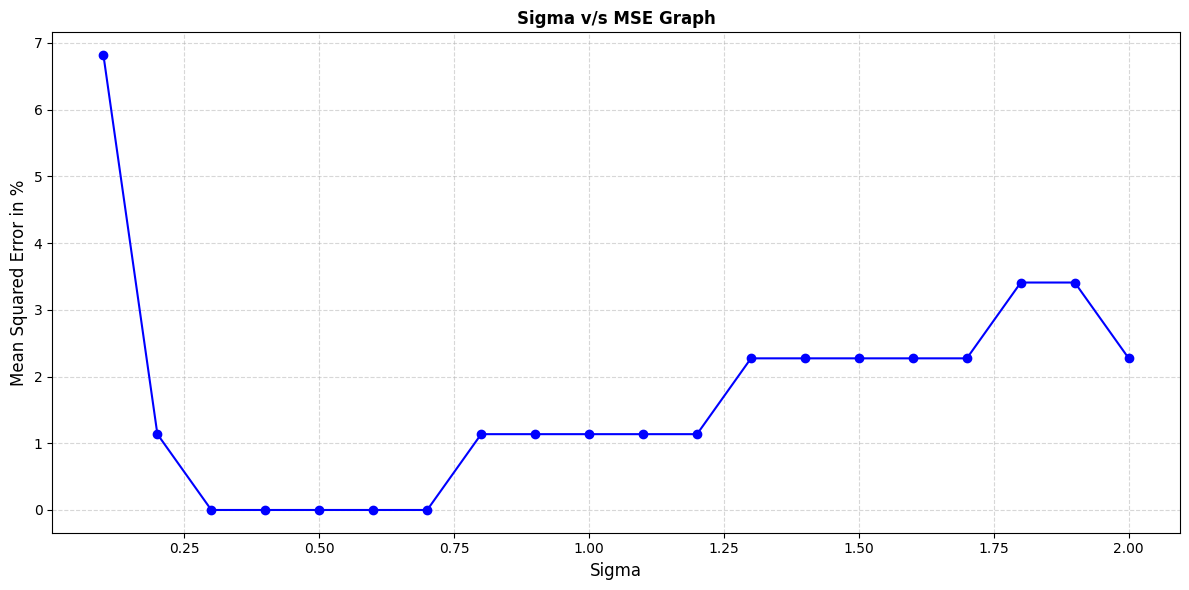

In [4758]:
acc_mse_plot(mse_list_3,sigma_list,mse=True)

20
100.0


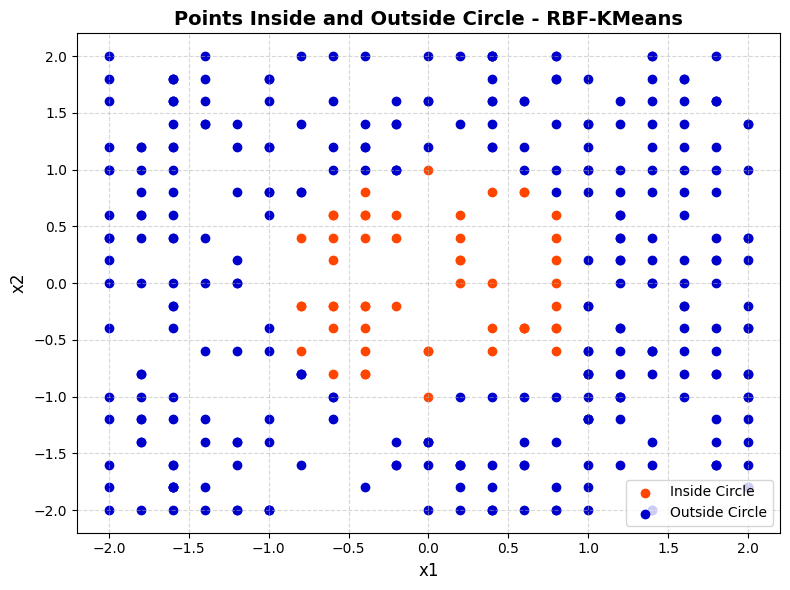

In [4759]:
print(len(output_3))
print(max(accuracy_list_3))
# for output in output_1:
plot(train_data,output_3[accuracy_list_3.index(max(accuracy_list_3))],4)

In [4760]:
len(weights_3)

20

## Validation

In [4761]:
val_output_3=[]
i=0
for sigma in sigma_list:
    val_output_3=RBF_NN_predict(train_data,rbf_centres_3,weights_3[i],val_data,val_op_labels,sigma,3,K=150)
    i=i+1
    

Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is:

In [4762]:
tst_accuracy_list_3

[96.62921348314607,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 98.87640449438202,
 98.87640449438202,
 98.87640449438202,
 98.87640449438202,
 98.87640449438202,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 97.75280898876404,
 97.75280898876404,
 97.75280898876404]

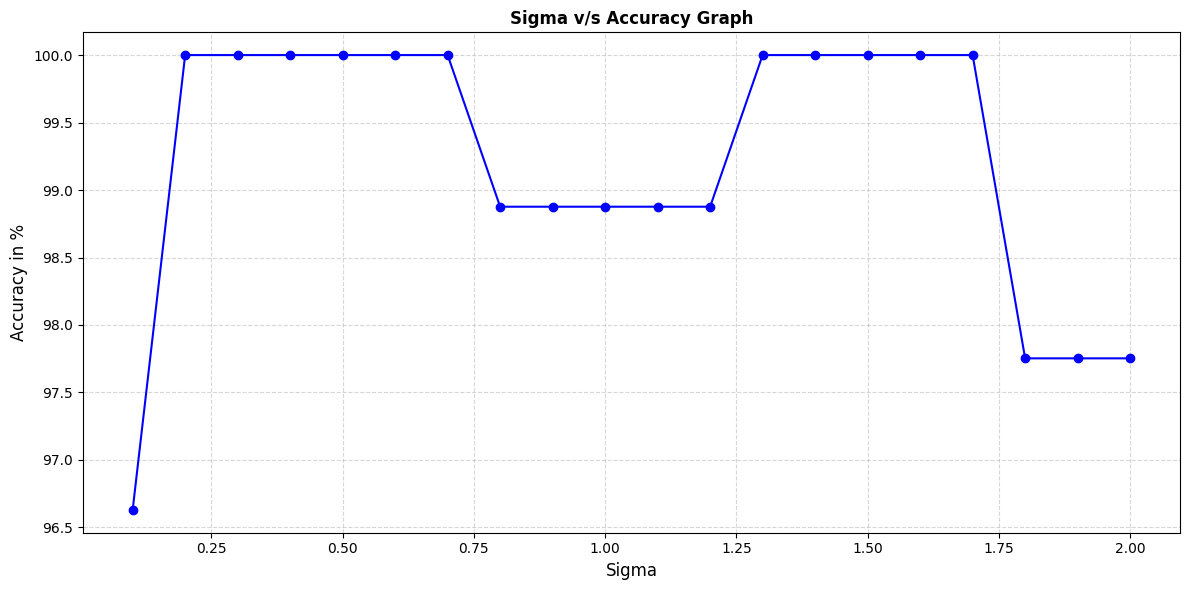

In [4763]:
acc_mse_plot(tst_accuracy_list_3,sigma_list)

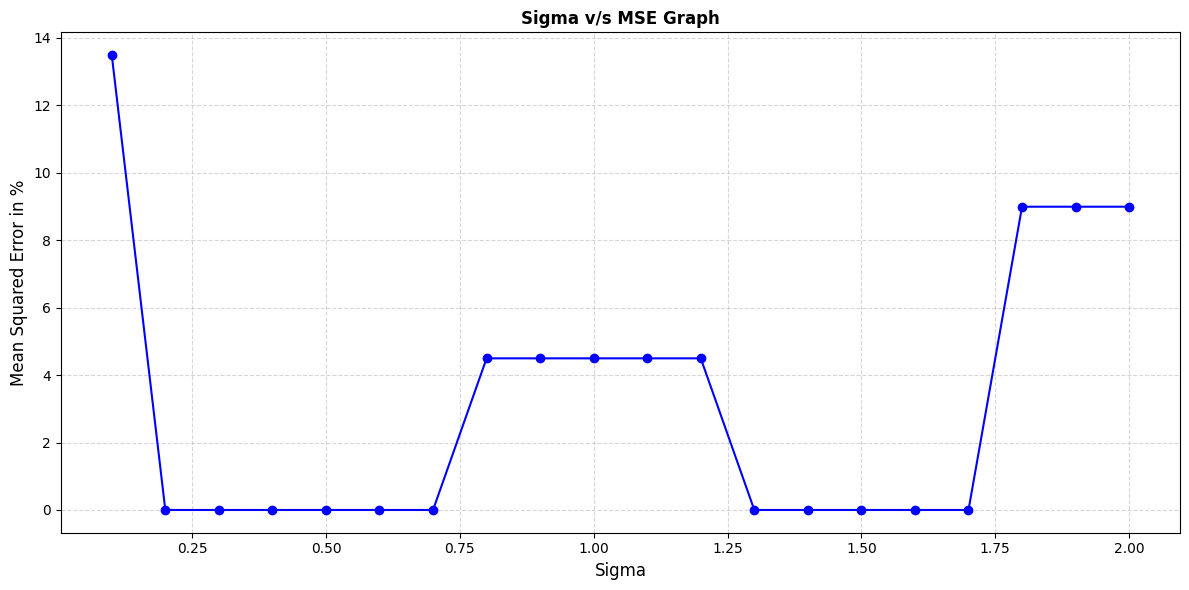

In [4764]:
acc_mse_plot(tst_mse_list_3,sigma_list,mse=True)

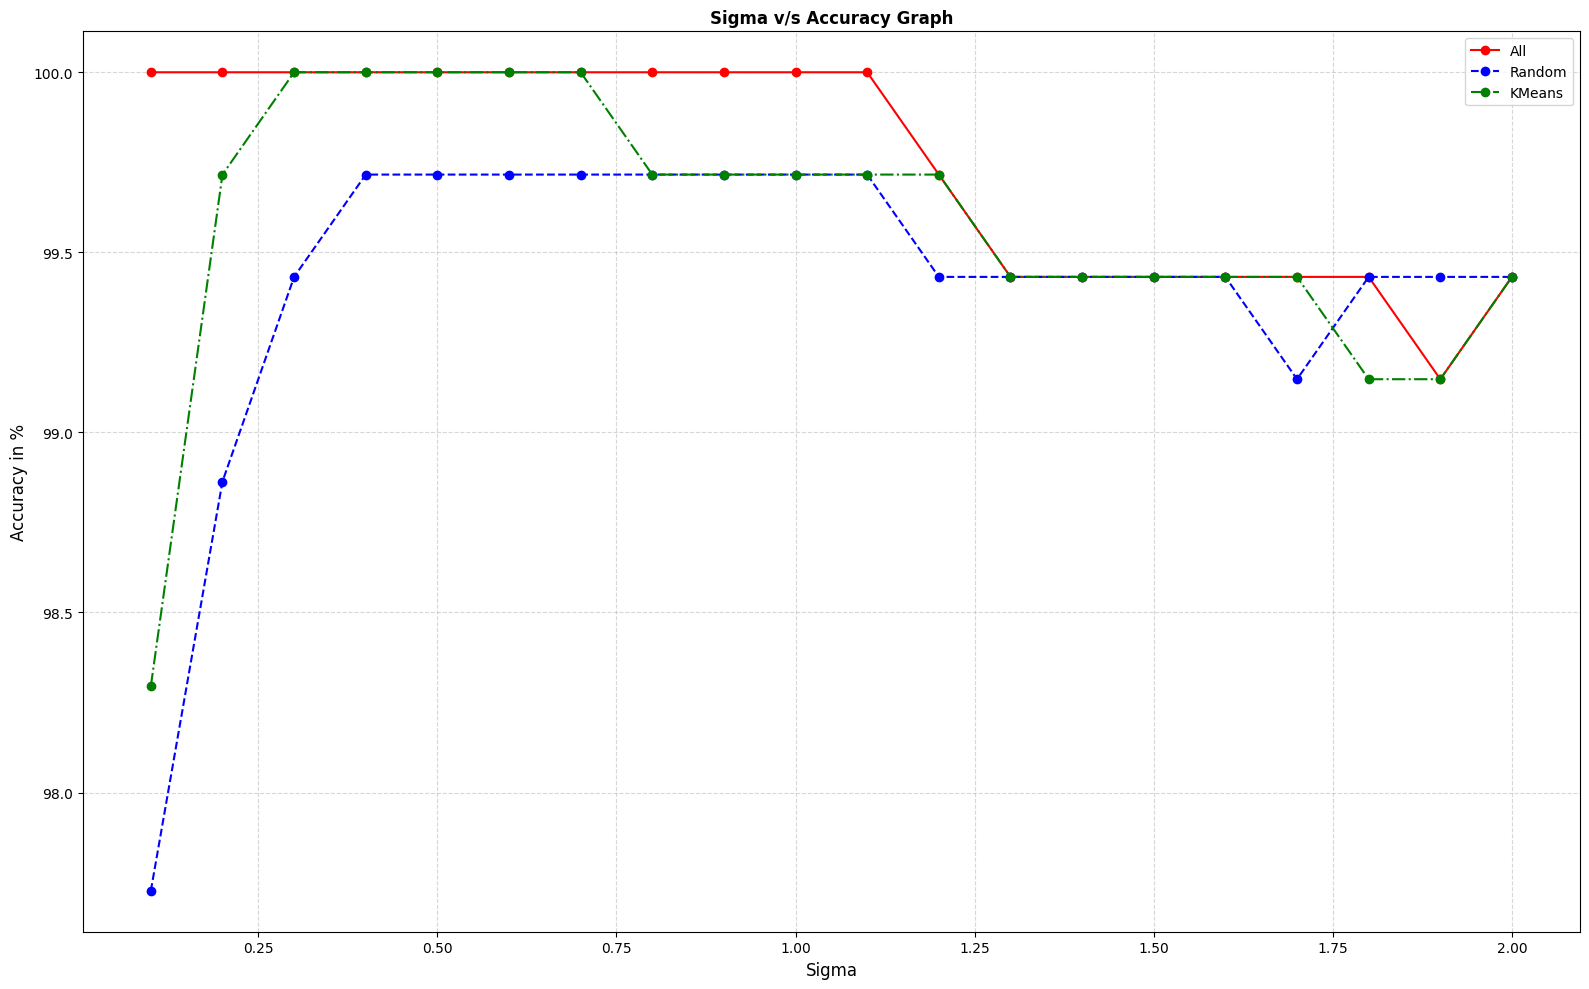

In [4765]:
comp_plot(accuracy_list_1,accuracy_list_2,accuracy_list_3,sigma_list)

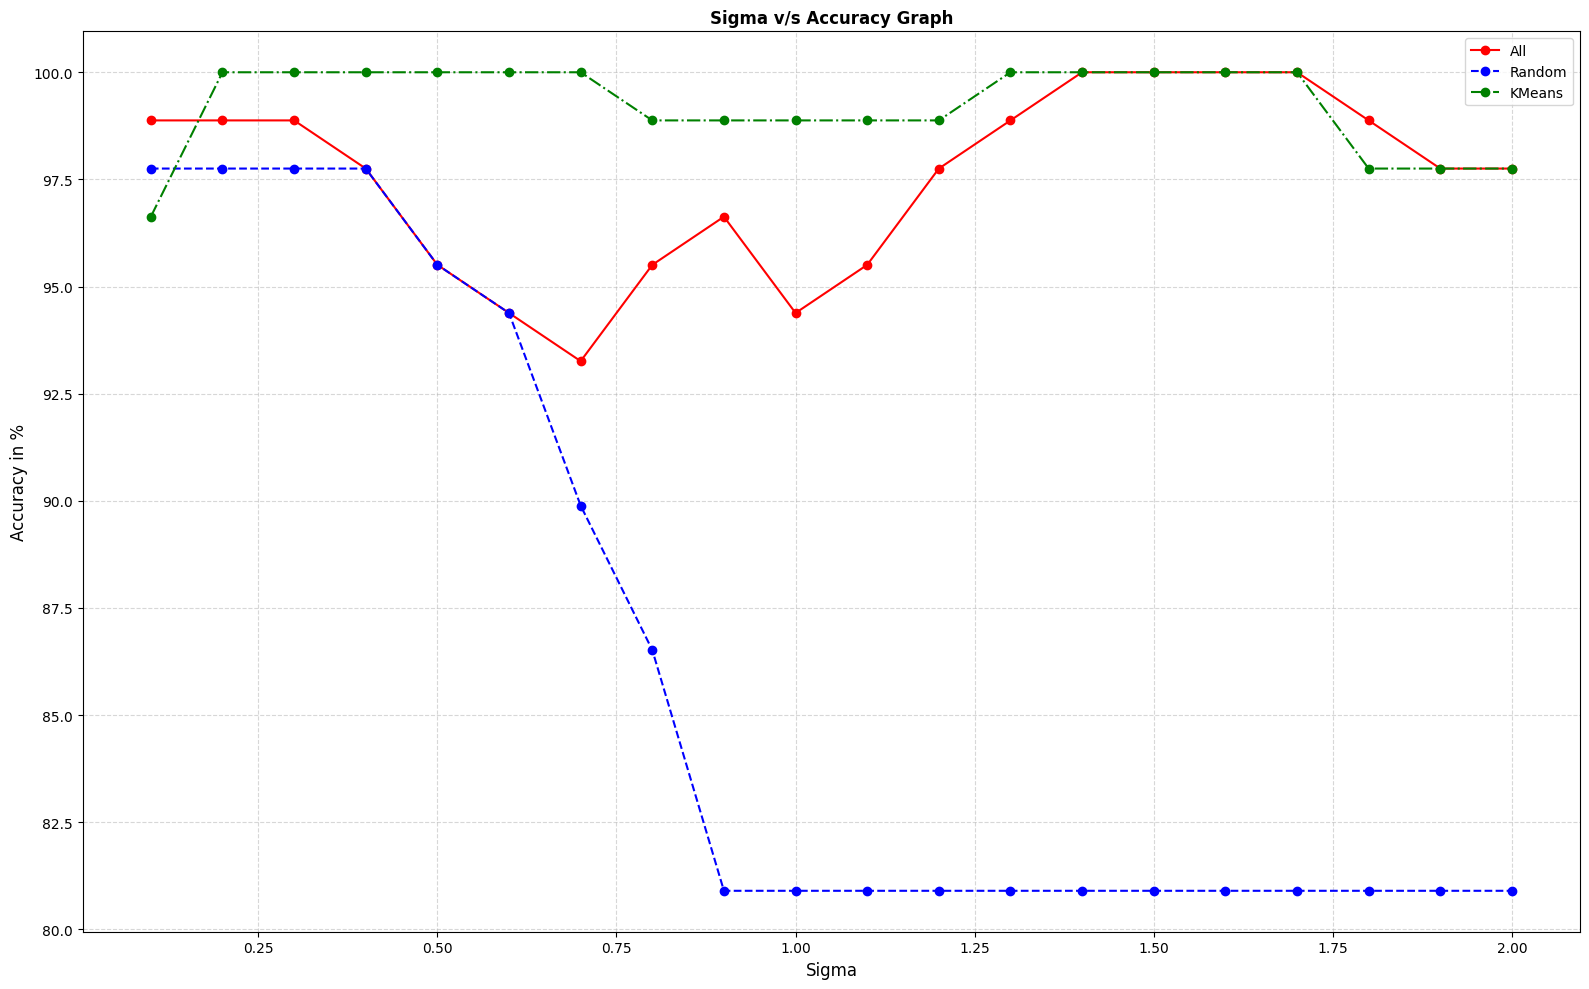

In [4766]:
comp_plot(tst_accuracy_list_1,tst_accuracy_list_2,tst_accuracy_list_3,sigma_list)

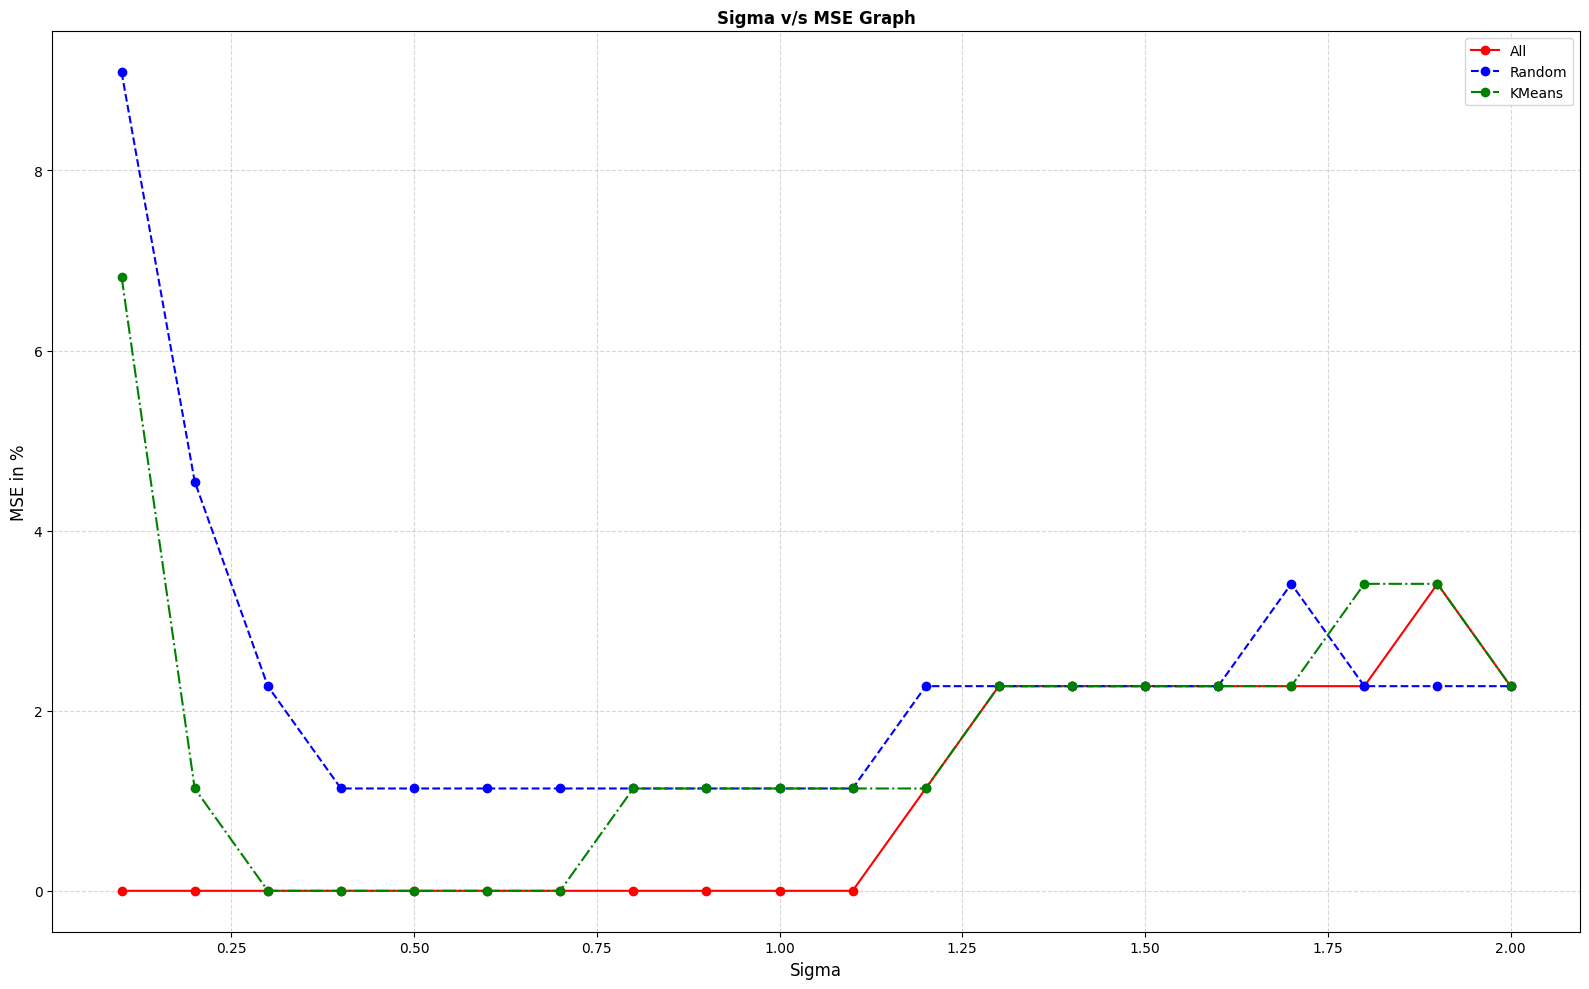

In [4767]:
comp_plot(tst_mse_list_1,tst_mse_list_2,tst_mse_list_3,sigma_list,mse=True)

In [4768]:
acc_df={'Sigma':sigma_list,'All':accuracy_list_1,'Random':accuracy_list_2,'KMeans':accuracy_list_3}
pd.DataFrame(acc_df)

,Sigma,All,Random,KMeans
0,0.1,100.000000,97.727273,98.295455
1,0.2,100.000000,98.863636,99.715909
2,0.3,100.000000,99.431818,100.000000
3,0.4,100.000000,99.715909,100.000000
4,0.5,100.000000,99.715909,100.000000
5,0.6,100.000000,99.715909,100.000000
6,0.7,100.000000,99.715909,100.000000
7,0.8,100.000000,99.715909,99.715909
8,0.9,100.000000,99.715909,99.715909
9,1.0,100.000000,99.715909,99.715909


In [4769]:
tst_acc_df={'Sigma':sigma_list,'All':tst_accuracy_list_1,'Random':tst_accuracy_list_2,'KMeans':tst_accuracy_list_3}
pd.DataFrame(tst_acc_df)

,Sigma,All,Random,KMeans
0,0.1,98.876404,97.752809,96.629213
1,0.2,98.876404,97.752809,100.000000
2,0.3,98.876404,97.752809,100.000000
3,0.4,97.752809,97.752809,100.000000
4,0.5,95.505618,95.505618,100.000000
5,0.6,94.382022,94.382022,100.000000
6,0.7,93.258427,89.887640,100.000000
7,0.8,95.505618,86.516854,98.876404
8,0.9,96.629213,80.898876,98.876404
9,1.0,94.382022,80.898876,98.876404
